TRABAJO PRACTICO PARA LA PLATAFORMA DE CODERHOUSE, EN EL QUE UTILIZO UN SET DE DATOS DE SINIESTROS VEHICULARES DE UNA CIUDAD PARA SACAR CONCLUSIONES, BASADAS EN GRÁFICOS Y PREDICCIONES, LOGRADAS CON LAS TÉCNICAS APRENDIDAS A LO LARGO DEL CURSO. 

EL LENGUAJE DE PROGRAMACIÓN UTILIZADO ES PYTHON Y LA LIBRERIA EN LA QUE SE BASA EL TRABAJO ES PANDAS.

COMIENZA CARGA DE DATOS

Cargo en primer lugar las librerias que usaré, luego cargo el set de datos elegido; este contiene datos de siniestros de tránsito en la Ciudad de Buenos Aires, entre los años 2015 y 2018. 

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, accuracy_score, f1_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
siniestros = 'victimas-siniestros.csv'
sin_df = pd.read_csv(siniestros)

C:\Users\Seguridad\AppData\Local\Temp\ipykernel_16580\1239150759.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  sin_df = pd.read_csv(siniestros)


COMIENZA EL PROCESO DE EXPLORACIÓN Y LIMPIEZA DEL DATASET

In [3]:
sin_df.sample(3)

,causa,rol,tipo,sexo,edad,mes,periodo,fecha,hora,lugar_hecho,...,semestre,x,y,geom,cantidad_victimas,comuna,geom_3857,tipo_colision1,participantes_victimas,participantes_acusados
15961,lesiones,conductor,moto,masculino,31.0,2.0,2018,2/16/2018,8:35:00,NaN,...,1,-58.400887,-34.619733,0101000020E610000017C62A4550334DC0086AEA69534F...,1,3.0,0101000020110F000022014141C9CC58C1BCE5E1DBE15F...,motovehiculo - vehiculo,moto,automovil
9434,lesiones,conductor,automovil,femenino,60.0,7.0,2015,7/13/2015,14:50:00,11 de septiembre y ruiz huidobro,...,2,-58.464692,-34.541136,0101000020E6100000CD3FB80A7B3B4DC0A2F6B6F44345...,1,13.0,0101000020110F0000B5F3ACF2B8D358C101D2EF77204B...,vehiculo - vehiculo,automovil,camion
16598,homicidio,peaton,peaton,masculino,NaN,5.0,2015,5/14/2015,7:00:00,av juan de garay 1227,...,1,-58.383171,-34.626880,0101000020E61000008131B4BF0B314DC0A136569D3D50...,1,1.0,0101000020110F0000A4FCCA37DCCA58C1831BE948C561...,peaton - vehiculo,peaton,automovil


In [4]:
sin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33234 entries, 0 to 33233
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   causa                         33234 non-null  object 
 1   rol                           32899 non-null  object 
 2   tipo                          32134 non-null  object 
 3   sexo                          33037 non-null  object 
 4   edad                          32675 non-null  float64
 5   mes                           33197 non-null  float64
 6   periodo                       33234 non-null  int64  
 7   fecha                         33173 non-null  object 
 8   hora                          33217 non-null  object 
 9   lugar_hecho                   29518 non-null  object 
 10  direccion_normalizada         32469 non-null  object 
 11  tipo_calle                    33234 non-null  object 
 12  direccion_normalizada_arcgis  32462 non-null  object 
 13  c

EN PRIMERA INSTANCIA DE LA EXPLORACION, VOY A ESTABLECER UN OBJETIVO GENERAL:

QUIERO MINIMIZAR LA CANTIDAD DE ACCIDENTES DE AUTOS, MOTOS Y BICICLETAS (en este ejemplo me contrataría gobierno de la Ciudad de Buenos Aires). PARA ESTO HABRIA QUE TOMAR MEDIDAS DE TODO TIPO, COMO CONTROLES POLICIALES, CARTELES PREVENTIVOS, ARREGLOS DE CALLE, CAMARAS-MULTA, ETC.

ES IMPORTANTE, EN ESTE PUNTO, IDENTIFICAR QUE VARIABLE PUEDO PREDECIR (O QUE VARIABLE PUEDO CREAR PARA PREDECIR) TENIENDO EN CUENTA LA INFORMACIÓN QUE TENGO DISPONIBLE PARA ESTE FIN. ME GUSTARÍA PODER PREDECIR EL TIPO DE CHOQUE POR EJEMPLO, PERO CON LA INFORMACIÓN DISPONIBLE NO ES POSIBLE OBTENER BUENOS RESULTADOS EN ESTE ESTUDIO. 

TENDIENDO EN CUENTA ESTO, VOY A ENCARAR EL ESTUDIO CON EL SIGUIENTE NORTE: 

- VOY A PREDECIR EL TIPO DE CALLE EN EL QUE SE PRODUCE UN ACCIDENTE, ESTE PUEDE SER 'calle', 'avenida' o 'autopista'. ES UN DATO IMPORTANTE PARA LA PLANIFICACIÓN DE CIERTAS MEDIDAS, COMO POR EJEMPLO CARTELES PREVENTIVOS EN LAS AVENIDAS, CONTROLES EN AUTOPISTAS, ETC.

- VOY A CREAR UNA COLUMNA QUE SEA SI EL SINIESTRO ES DE DIA O DE NOCHE, PARA LUEGO PREDECIR CUANDO SUCEDE CIERTO TIPO DE SINIESTRO, SE PUEDE UTILIZAR PARA LA TOMA DE DECISIONES SOBRE CUANDO PONER UN CONTROL POLICIAL EN ALGUNA CALLE (por ejemplo, si en palermo hay muchos choques a la noche, el control policial podría ponerlo en ese rango horario para que los autos bajen la velocidad).

- VOY A CREAR UNA COLUMNA LLAMADA 'finde' E INTENTARÉ PREDECIR SU VALOR, HABIENDO ELIMINADO LAS COLUMNAS QUE TENGAN INFORMACIÓN SOBRE LA FECHA. ESTO ES IMPORTANTE EN EL CASO QUE HAYA CIERTAS CALLES QUE SEAN MAS PELIGROSAS EN EL FIN DE SEMANA. 


FINALMENTE, COMPARARÉ LOS MODELOS UTILIZADOS PARA PREDECIR EL TIPO DE CALLE EN EL QUE SE PRODUJO EL SINIESTRO Y ELEGIRÉ EL QUE MEJOR RESULTADO DÉ.

-------------------------------------------------------------------------------------------------------------------------------

CON ESTE OBJETIVO EN MENTE, VOY A ELEGIR QUE COLUMNAS SON LAS QUE MAS INFORMACION PUEDEN APORTAR Y CUALES SON LAS QUE TIENEN INFORMACION REDUNDANTE.

EN UNA PRIMERA IMPRESION, ASUMO QUE LAS COLUMNAS MAS IMPORTANTES SON:

- causa
- rol
- tipo
- sexo
- edad
- fecha
- hora
- tipo_calle
- calle1
- calle2
- x
- y
- cantidad_victimas
- comuna
- participantes_victimas
- participantes_acusados

EL RESTO DE COLUMAS CONTIENEN INFORMACION QUE APARECE EN ESTAS COLUMNAS SELECCIONADAS, PERO EN OTRO FORMATO.

PROCEDO A QUEDARME SOLO CON LAS COLUMNAS ELEGIDAS, REVISO LOS DATOS NULOS Y LOS ESTUDIO EN UN GRAFICO PARA BUSCAR PATRONES EN ELLOS.

In [5]:
sin_df = sin_df[['causa','rol','tipo','sexo','edad','fecha','hora','tipo_calle','calle1','calle2','x','y','cantidad_victimas','comuna','tipo_colision1','participantes_acusados','participantes_victimas']]
sin_df.isnull().sum()

causa                        0
rol                        335
tipo                      1100
sexo                       197
edad                       559
fecha                       61
hora                        17
tipo_calle                   0
calle1                     765
calle2                    8247
x                         1095
y                         1095
cantidad_victimas            0
comuna                    1098
tipo_colision1            1343
participantes_acusados     677
participantes_victimas    1131
dtype: int64

<AxesSubplot:>

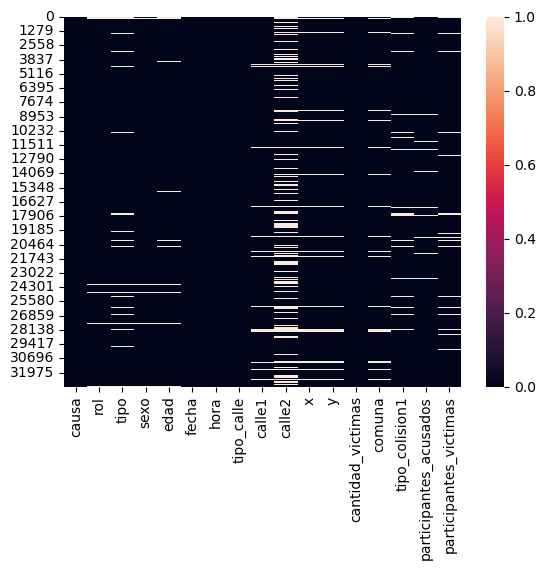

In [6]:
sns.heatmap(sin_df[['causa','rol','tipo','sexo','edad','fecha','hora','tipo_calle','calle1','calle2','x','y','cantidad_victimas','comuna','tipo_colision1','participantes_acusados','participantes_victimas']].isnull())

BORRO LAS FILAS QUE TIENEN EL CAMPO FECHA Y HORA VACIOS, PORQUE SON MUY POCOS DATOS QUE PIERDO.

In [7]:
sin_df.dropna(subset=['fecha','hora'],inplace=True)
sin_df[['fecha','hora']].isnull().sum()

fecha    0
hora     0
dtype: int64

AHORA VOY A RELLENAR LOS CAMPOS CON VALOR NULO

In [8]:
sin_df['rol'].fillna('sin_data',inplace=True)
sin_df['sexo'].fillna('sin_data',inplace=True)
sin_df['calle1'].fillna('sin_data',inplace=True)
sin_df['calle2'].fillna('sin_data',inplace=True)
sin_df['x'].fillna(-1,inplace=True)
sin_df['y'].fillna(-1,inplace=True)
sin_df['edad'].fillna(sin_df.edad.mean(),inplace=True)
sin_df['comuna'].fillna(0,inplace=True)

In [9]:
sin_df['tipo'].fillna('sin_data',inplace=True)
sin_df['tipo_colision1'].fillna('sin_data',inplace=True)
sin_df['participantes_acusados'].fillna('sin_data',inplace=True)
sin_df['participantes_victimas'].fillna('sin_data',inplace=True)

AHORA VOY A SIMPLIFICAR LAS COLUMNAS 'tipo' Y 'tipo_colision1' PARA QUE SEAN UTILIZABLES POR UN ALGORITMO.

In [10]:
def simplificar_tipocol(tipo):

    if '-' in tipo:
        ac, vi = tipo.split('-')
    else:
        return tipo
    
    if tipo == 'vehiculo - motovehiculo' or tipo == 'motovehiculo - vehiculo':
        return 'motovehiculo - vehiculo'
    elif 'peaton' in tipo:
        return 'peaton - vehiculo'
    elif 'bicicleta' in tipo:
        return 'bicicleta - vehiculo'
    elif tipo == 'traccion a sangre - vehiculo' or tipo == 'motovehiculo - traccion a sangre' or tipo == 'motovehiculo - tren' or tipo == 'subte - vehiculo':
        return 'sin_data'
    else:
        return tipo

def simplificar_tipo(tipo):
    
    if tipo == 'auto pfa / movil / gendarmeria / metropolitana / moto movil' or tipo == 'vehiculo oficial':
        st = 'fuerza seguridad'
    elif tipo == 'transporte de cargas / grua' or tipo == 'utilitario':
        st = 'camion'
    elif tipo == 'transporte escolar' or tipo == 'omnibus / minibus':
        st = 'transporte_publico'
    elif tipo == 'ambulancia':
        st = 'camion'
    elif tipo == 'traccion a sangre' or tipo == 'autobomba' or tipo == 'patineta' or tipo == 'cuatriciclo' or tipo == 'tren / subte' or tipo == 'tren / subte / tranvia' or tipo == 'vehiculo rural' or tipo == 'otros':
        st = 'sin_data'
    else:
        return tipo
    return st

In [11]:
sin_df['tipo'] = sin_df['tipo'].apply(simplificar_tipo)#.astype('|S80')

sin_df['tipo_colision1'] = sin_df['tipo_colision1'].apply(simplificar_tipocol)#.astype('|S80')

In [12]:
def simplificar_acusado(ac):    
    if ('moto' in ac):
        return 'motovehiculo'
    elif ('auto' in ac):
        return 'automovil'
    elif (('rural' in ac) | ('camion' in ac) | ('utilitario' in ac)):
        return 'camion'
    elif ('peaton' in ac) | ('patineta' in ac):
        return 'peaton'
    elif ('bici' in ac):
        return 'peaton'
    elif (('taxi' in ac) | ('remis' in ac) | ('bus' in ac) | ('publico' in ac)):
        return 'transporte_publico'
    elif (('transporte' in ac) | ('ambulancia' in ac) | ('fuerza' in ac) | ('tren' in ac) | ('tranvia' in ac) | ('oficial' in ac)):
        return 'transporte_publico'
    else:
        return 'sin_data'

In [13]:
sin_df.participantes_acusados = sin_df.participantes_acusados.apply(simplificar_acusado)
sin_df.participantes_acusados.value_counts()

automovil             19132
transporte_publico     6374
motovehiculo           3733
camion                 2880
sin_data                759
peaton                  284
Name: participantes_acusados, dtype: int64

DEBERIA RELLENAR LOS NULOS DE 'tipo' CON INFORMACION DE OTRAS COLUMNAS PARA MEJORAR LA CALIDAD DE LA INFORMACION

In [14]:
#sin_df.loc[sin_df.tipo == 'sin_data','tipo'] = (sin_df.participantes_acusados)

#sin_df.loc[sin_df.participantes_acusados == 'sin_data','participantes_acusados'] = (sin_df.tipo)

#sin_df.loc[sin_df.tipo_colision1 == 'sin_data','tipo_colision1'] = (sin_df.participantes_acusados + ' - ' +sin_df.participantes_victimas)

CATEGORIZO LA COLUMNA "rol", QUE ME PARECE UN DATO IMPORTANTE

In [15]:
def simplificar_rol(rol):
    
    if 'peaton' in rol:
        return 'peaton'
    elif 'ciclista' in rol:
        return 'ciclista'
    elif 'pasajero' in rol:
        return 'pasajero'
    else:
        return rol

In [16]:
sin_df['rol'] = sin_df['rol'].apply(simplificar_rol)
sin_df.rol.value_counts()

conductor    17606
peaton        7842
pasajero      5493
ciclista      1889
sin_data       332
Name: rol, dtype: int64

EN LOS SIGUIENTES CASILLEROS VOY A LIMPIAR Y NORMALIZAR COLUMNAS (Lo puedo hacer luego con label encoder, pero decido hacerlo manual en este paso para tener control del valor que le asigno a cada dato)

In [17]:
def normalizar_causa(causa):
    if causa == 'lesiones':
        return 0
    elif causa == 'homicidio':
        return 1
    else:
        return -1


def normalizar_sexo(sexo):
    if sexo == 'masculino':
        return 0
    elif sexo == 'femenino':
        return 1
    else:
        return -1
    
def normalizar_tipo_calle(calle):
    if calle == 'autopista':
        return 0
    elif calle == 'avenida':
        return 1
    elif calle == 'calle':
        return 2
    else:
        return -1
    
sin_df['sexo'] = sin_df['sexo'].apply(normalizar_sexo)
sin_df['causa'] = sin_df['causa'].apply(normalizar_causa)
sin_df['tipo_calle'] = sin_df['tipo_calle'].apply(normalizar_tipo_calle)
sin_df.value_counts('tipo_calle')

# masculino -> 0
# femenino -> 1
# sin data -> -1

# lesiones -> 0
# muerte -> 1

tipo_calle
1    21355
2    11659
0      148
dtype: int64

In [18]:
def edades(edad):
    rango = 0
    
    if (edad<20):
        rango=1
    elif (edad<40):
        rango=2
    elif (edad<60):
        rango=3
    else:
        rango=4
    return rango

sin_df['rango_edad'] = sin_df['edad'].apply(edades)
sin_df.value_counts('rango_edad')

rango_edad
2    19208
3     7427
4     3595
1     2932
dtype: int64

LE DOY UN FORMATO DESEADO A LA HORA Y FECHA

In [19]:
def extraer_hora(hora):
    return hora.hour

sin_df['hora'] = pd.to_datetime(sin_df['hora']).apply(extraer_hora)
sin_df['hora'] = sin_df['hora'].astype(int)
sin_df.value_counts('hora').head()

hora
18    2215
13    2186
14    2115
17    2106
12    2029
dtype: int64

In [20]:
def crear_fecha(fecha):

    if "/" in fecha:
        fecha = fecha.split("/")
        fecha[0] = int(fecha[0])
        fecha[1] = int(fecha[1])
        fecha[2] = int(fecha[2])
        aux = fecha[1]
        fecha[1] = fecha[0]
        fecha[0] = aux
        return fecha
    
    elif "-" in fecha:
        fecha = fecha.split("-")
        fecha[0] = int(fecha[0])
        fecha[1] = int(fecha[1])
        fecha[2] = int(fecha[2])
        fecha[2] = 2000 + fecha[2]
        return fecha


def dia(d):
    return d[0]

def mes(d):
    return d[1]

def anio(d):
    return d[2]

In [21]:
sin_df['rango_horario'] = sin_df.hora.apply(lambda x: 
                                            0 if (x < 5)
                                            else 1 if (x < 14)
                                            else 2 if (x < 21)
                                            else 0)

sin_df.rango_horario.value_counts()

# 0 -> Noche y Madrugada
# 1 -> Mañana
# 2 -> Tarde

2    13977
1    13411
0     5774
Name: rango_horario, dtype: int64

In [22]:
#sin_df = sin_df.dropna(subset='fecha')
sin_df['fecha_norm'] = sin_df['fecha'].apply(crear_fecha)

sin_df['d'] = sin_df['fecha_norm'].apply(dia)
sin_df['m'] = sin_df['fecha_norm'].apply(mes)
sin_df['a'] = sin_df['fecha_norm'].apply(anio)

In [23]:
sin_df['causa'] = sin_df['causa'].astype(int)
sin_df['sexo'] = sin_df['sexo'].astype(int)
sin_df['edad'] = sin_df['edad'].astype(int)
sin_df['tipo_calle'] = sin_df['tipo_calle'].astype(int)
sin_df['cantidad_victimas'] = sin_df['cantidad_victimas'].astype(int)
sin_df['comuna'] = sin_df['comuna'].astype(int)
sin_df['rango_edad'] = sin_df['rango_edad'].astype(int)
sin_df['rango_horario'] = sin_df['rango_horario'].astype(int)
sin_df['d'] = sin_df['d'].astype(int)
sin_df['m'] = sin_df['m'].astype(int)
sin_df['a'] = sin_df['a'].astype(int)
sin_df['h'] = sin_df['hora']
sin_df.drop(columns='hora',inplace=True)
 
sin_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 33162 entries, 0 to 33232
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   causa                   33162 non-null  int32  
 1   rol                     33162 non-null  object 
 2   tipo                    33162 non-null  object 
 3   sexo                    33162 non-null  int32  
 4   edad                    33162 non-null  int32  
 5   fecha                   33162 non-null  object 
 6   tipo_calle              33162 non-null  int32  
 7   calle1                  33162 non-null  object 
 8   calle2                  33162 non-null  object 
 9   x                       33162 non-null  float64
 10  y                       33162 non-null  float64
 11  cantidad_victimas       33162 non-null  int32  
 12  comuna                  33162 non-null  int32  
 13  tipo_colision1          33162 non-null  object 
 14  participantes_acusados  33162 non-null

FINALIZA EL PROCESO DE LIMPIEZA

-------------------------------------------------------------------------------------------------------------------------

COMIENZA AGREGACIÓN DE DATOS

UTILIZARE UN SET DE DATOS OBTENIDO DE LA PAGINA DE LA NASA, CON INFORMACIÓN DEL CLIMA EN CABA POR HORA (entre 2015 y 2018), PARA COMBINAR CON MI DATASET UTILIZANDO LA FUNCIÓN MERGE

In [24]:
clima = 'clima_caba.csv'
clima_df = pd.read_csv(clima)
clima_df.rename(columns={'viento;;;;;;':'viento'}, inplace=True)

#NO SE PORQUE AGREGA LA COLUMNA VIENTO CON ESE NOMBRE, PARA NO PERDER TIEMPO LA CORRIJO MANUALMENTE

In [25]:
sin_df = sin_df.merge(clima_df,how='left',left_on=['d','m','a','h'],right_on=['d','m','a','h'])
sin_df.sample(3)

,causa,rol,tipo,sexo,edad,fecha,tipo_calle,calle1,calle2,x,...,rango_horario,fecha_norm,d,m,a,h,temp,hum,precip,viento
19523,0,ciclista,bicicleta,0,6,2/13/2016,2,rondeau,sin_data,-58.414462,...,2,"[13, 2, 2016]",13,2,2016,20,26.05,67.00,0.00,6.90
19784,0,pasajero,transporte publico,1,85,3/21/2016,1,"scalabrini ortiz, raul av.",camargo,-58.439957,...,1,"[21, 3, 2016]",21,3,2016,9,19.84,71.69,0.05,4.17
6806,0,conductor,moto,0,41,11-08-17,1,varela av.,primera junta,-58.458553,...,2,"[11, 8, 2017]",11,8,2017,19,16.36,96.56,0.24,4.23


<AxesSubplot:>

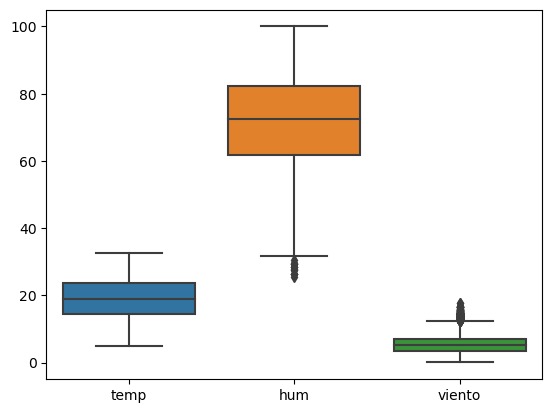

In [26]:
sns.boxplot(sin_df[['temp','hum','viento']])

Veo que en este caso los outliers no cambiaran en gran medida la normalización.

Voy a categorizar las columnas viento y precip para que sean utilizables por los diferentes clasificadores, para eso reviso la distibución de la variable.

In [27]:
sin_df.viento

0        9.80
1        4.15
2        8.10
3        7.27
4        3.19
         ... 
33157    6.56
33158    9.06
33159    9.23
33160    9.23
33161    8.93
Name: viento, Length: 33162, dtype: float64

<AxesSubplot:ylabel='Frequency'>

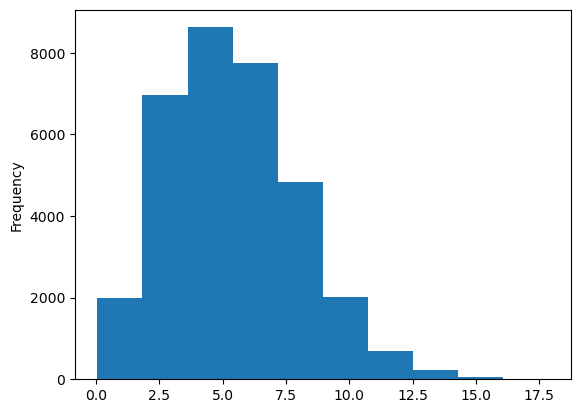

In [28]:
sin_df.viento.plot(kind='hist')

In [29]:
vmod_mask = (sin_df.loc[(sin_df.viento >= 3.7) & (sin_df.viento <= 7)]).index
vmin_mask = (sin_df.loc[(sin_df.viento < 3.7)]).index
vmax_mask = (sin_df.loc[(sin_df.viento > 7)]).index


sin_df.loc[vmin_mask, 'viento'] = 0
sin_df.loc[vmod_mask, 'viento'] = 1
sin_df.loc[vmax_mask, 'viento'] = 2

sin_df.viento = sin_df.viento.astype(int)

sin_df.viento.value_counts()

1    15352
0     9329
2     8481
Name: viento, dtype: int64

In [30]:
p_mask = (sin_df.loc[(sin_df.precip >= 0.1)]).index
no_p_mask = (sin_df.loc[(sin_df.precip < 0.1)]).index

sin_df.loc[p_mask, 'precip'] = 0
sin_df.loc[no_p_mask, 'precip'] = 1

sin_df.precip = sin_df.precip.astype(int)

sin_df.precip.value_counts()

1    29798
0     3364
Name: precip, dtype: int64

CREO UNA VARIABLE QUE CONTENGA INFORMACION DEL VIENTO Y LAS PRECIPITACIONES, esta indicaría la dificultad de manejo por condiciones climaticas

In [31]:
sin_df['dif_clima'] = sin_df['viento'] + (2*sin_df['precip'])

AHORA VOY A CREAR UNA COLUMNA QUE CONTENGA EL NOMBRE DEL DIA EN EL QUE SUCEDIÓ EL SINIESTRO

In [32]:
sin_df['fecha_norm'] = sin_df['d'].astype(str) + '-' + sin_df['m'].astype(str) + '-' + sin_df['a'].astype(str)
sin_df['fecha'] = pd.to_datetime(sin_df['fecha_norm'],format='%d-%m-%Y', errors='coerce')

sin_df['nom_dia'] = sin_df['fecha'].dt.strftime('%A')

sin_df[['a','m','d','fecha','nom_dia']].sample(3)

,a,m,d,fecha,nom_dia
688,2015,6,12,2015-06-12,Friday
3254,2016,4,21,2016-04-21,Thursday
5290,2017,2,17,2017-02-17,Friday


CREARÉ OTRA COLUMNA QUE DIGA SI ES FIN DE SEMANA O NO

In [33]:
mask = (sin_df.loc[(sin_df.nom_dia == 'Sunday') | (sin_df.nom_dia == 'Saturday')]).index
sin_df.loc[mask, 'finde'] = 1
sin_df.loc[sin_df.finde!=1, 'finde'] = 0
sin_df.finde = sin_df.finde.astype(int)
sin_df[['fecha','nom_dia','finde']].sample(10)

,fecha,nom_dia,finde
9703,2015-09-16,Wednesday,0
11988,2016-06-30,Thursday,0
15500,2017-10-15,Sunday,1
2140,2015-03-24,Tuesday,0
8967,2015-08-07,Friday,0
3584,2016-04-06,Wednesday,0
15714,2018-08-01,Wednesday,0
3266,2016-04-22,Friday,0
11271,2016-03-19,Saturday,1
8708,2015-05-01,Friday,0


UTILIZANDO UN SET DE DATOS OBTENIDO MEDIANTE CHAT-GPT QUE CONTIENE LOS DIAS FERIADOS, AGREGARÉ ESTE DETALLE AL DATASET EN UNA COLUMNA APARTE

In [34]:
feriados = 'feriados.csv'
fer_df = pd.read_csv(feriados)
fer_df.columns = ['d','m','a','feriado']
fer_df.feriado = 1

In [35]:
sin_df = sin_df.merge(fer_df,how='left',left_on=['d','m','a'],right_on=['d','m','a'])

In [36]:
sin_df.feriado.fillna(0, inplace=True)
sin_df.feriado = sin_df.feriado.astype(int)
sin_df.feriado.value_counts()

0    32337
1      825
Name: feriado, dtype: int64

CORROBORÉ QUE SE HAYAN AGREGADO CORRECTAMENTE LOS FERIADOS. También agregare al fin de semana los dias viernes pasadas las 19hs. 

In [37]:
#AGREGO LOS VIERNES A LA TARDE A MI COLUMNA 'finde'

#v_mask = (sin_df.loc[(sin_df.nom_dia == 'Friday') & (sin_df.h > 18)]).index
#sin_df.loc[v_mask, 'finde'] = 1

In [38]:
sin_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33162 entries, 0 to 33161
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   causa                   33162 non-null  int32         
 1   rol                     33162 non-null  object        
 2   tipo                    33162 non-null  object        
 3   sexo                    33162 non-null  int32         
 4   edad                    33162 non-null  int32         
 5   fecha                   33162 non-null  datetime64[ns]
 6   tipo_calle              33162 non-null  int32         
 7   calle1                  33162 non-null  object        
 8   calle2                  33162 non-null  object        
 9   x                       33162 non-null  float64       
 10  y                       33162 non-null  float64       
 11  cantidad_victimas       33162 non-null  int32         
 12  comuna                  33162 non-null  int32 

FIN DE LA AGREGACIÓN DE DATOS

--------------------------------------------------------------------------------------------------------------------------

COMIENZA PROCESO DE PREDICCIÓN

Primero voy a predecir una variable importante desde mi punto de vista, el tipo de calle en el que se produce un siniestro, dadas las columnas elegidas como variable independiente, para el caso: 

['causa','tipo','rol','comuna','tipo_colision1','d','m','h','participantes_acusados','dif_clima','rango_edad','finde']

Obviamente me gustaria utilizar las columnas 'x' e 'y' pero estas aportan datos geograficos que pueden hacer inducir al algoritmo el tipo de calle por repetición (puede causar overfitting)

In [39]:
X = sin_df[['causa','tipo','rol','comuna','tipo_colision1','d','m','h','participantes_acusados','participantes_victimas','dif_clima','edad','cantidad_victimas','nom_dia']]
y = sin_df['tipo_calle']

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33162 entries, 0 to 33161
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   causa                   33162 non-null  int32 
 1   tipo                    33162 non-null  object
 2   rol                     33162 non-null  object
 3   comuna                  33162 non-null  int32 
 4   tipo_colision1          33162 non-null  object
 5   d                       33162 non-null  int32 
 6   m                       33162 non-null  int32 
 7   h                       33162 non-null  int32 
 8   participantes_acusados  33162 non-null  object
 9   participantes_victimas  33162 non-null  object
 10  dif_clima               33162 non-null  int32 
 11  edad                    33162 non-null  int32 
 12  cantidad_victimas       33162 non-null  int32 
 13  nom_dia                 33162 non-null  object
dtypes: int32(8), object(6)
memory usage: 2.8+ MB


In [40]:
le = LabelEncoder()
le.fit(X.rol)
X.rol = le.transform(X.rol)

le.fit(X.tipo_colision1)
X.tipo_colision1 = le.transform(X.tipo_colision1)

le.fit(X.participantes_acusados)
X.participantes_acusados = le.transform(X.participantes_acusados)

le.fit(X.participantes_victimas)
X.participantes_victimas = le.transform(X.participantes_victimas)

le.fit(X.tipo)
X.tipo = le.transform(X.tipo)

le.fit(X.nom_dia)
X.nom_dia = le.transform(X.nom_dia)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33162 entries, 0 to 33161
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   causa                   33162 non-null  int32
 1   tipo                    33162 non-null  int32
 2   rol                     33162 non-null  int32
 3   comuna                  33162 non-null  int32
 4   tipo_colision1          33162 non-null  int32
 5   d                       33162 non-null  int32
 6   m                       33162 non-null  int32
 7   h                       33162 non-null  int32
 8   participantes_acusados  33162 non-null  int32
 9   participantes_victimas  33162 non-null  int32
 10  dif_clima               33162 non-null  int32
 11  edad                    33162 non-null  int32
 12  cantidad_victimas       33162 non-null  int32
 13  nom_dia                 33162 non-null  int32
dtypes: int32(14)
memory usage: 2.0 MB


C:\Users\Seguridad\AppData\Local\Temp\ipykernel_16580\3726546931.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rol = le.transform(X.rol)
C:\Users\Seguridad\AppData\Local\Temp\ipykernel_16580\3726546931.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.tipo_colision1 = le.transform(X.tipo_colision1)
C:\Users\Seguridad\AppData\Local\Temp\ipykernel_16580\3726546931.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [42]:
modelo_rf = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)
modelo_rf.fit(X_train, y_train)

y_train_pred = modelo_rf.predict(X_train)
y_test_pred = modelo_rf.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
print('% de aciertos sobre el set de entrenamiento:',train_accuracy*100)

test_accuracy = accuracy_score(y_test, y_test_pred)
print('% de aciertos sobre el set de evaluación:',test_accuracy*100)

C:\Users\Seguridad\AppData\Local\Temp\ipykernel_16580\1174985466.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(X_train, y_train)


% de aciertos sobre el set de entrenamiento: 70.06418817042174
% de aciertos sobre el set de evaluación: 66.86099105437732


Es un buen resultado, voy a compararlo con otro algoritmo, utilizando las mismas variables X e y 

In [43]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

modelo_xgb = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=6, random_state=42)
modelo_xgb.fit(X_train, y_train)

y_train_pred = modelo_xgb.predict(X_train)
y_test_pred = modelo_xgb.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
print('% de aciertos sobre el set de entrenamiento:',train_accuracy*100)

test_accuracy = accuracy_score(y_test, y_test_pred)
print('% de aciertos sobre el set de evaluación:',test_accuracy*100)

c:\ProgramData\Miniconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


% de aciertos sobre el set de entrenamiento: 69.83155990177917
% de aciertos sobre el set de evaluación: 67.09217006734345


In [45]:
importancia = pd.DataFrame()
importancia['feature'] = pd.Series(X.columns)
importancia['imp'] = modelo_rf.feature_importances_
importancia.sort_values(by='imp', ascending=False)

,feature,imp
3,comuna,0.262123
11,edad,0.115070
7,h,0.099918
5,d,0.081790
6,m,0.065086
9,participantes_victimas,0.058280
8,participantes_acusados,0.053704
1,tipo,0.052262
4,tipo_colision1,0.051558
13,nom_dia,0.048278


In [46]:
importancia = pd.DataFrame()
importancia['feature'] = pd.Series(X.columns)
importancia['imp'] = modelo_xgb.feature_importances_
importancia.sort_values(by='imp', ascending=False)

,feature,imp
3,comuna,0.165149
1,tipo,0.126160
0,causa,0.096152
8,participantes_acusados,0.080303
4,tipo_colision1,0.069261
12,cantidad_victimas,0.065734
9,participantes_victimas,0.063116
7,h,0.059413
11,edad,0.051460
2,rol,0.050739


NO PUEDO SACAR NINGUNA CONCLUSIÓN DEL FEATURE IMPORTENCE, YA QUE UN ALGORITMO CLASIFICA COMO POCO IMPORTANTES A LOS FEATURES QUE EL OTRO CLASIFICA COMO IMPORTANTES

EL MEJOR MODELO HASTA AHORA FUE EL CLASIFICADOR DE RANDOM FOREST (por poca diferencia). AJUSTARÉ LOS PARAMETROS Y VOLVERE A HACER LAS PRUEBAS PARA DEFINIR EL MEJOR MODELO PARA LA PREDICCIÓN DEL TIPO DE CALLE

In [49]:
parameters = {
    'max_depth': [2, 3, 6],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [300, 500, 100, 900],
}

grid_search = GridSearchCV(estimator=modelo_xgb, param_grid=parameters, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Obtengo los mejores hiperparámetros
best_params_xgb = grid_search.best_params_

print("Mejores parametros XGboost: ", best_params_xgb)

Mejores parametros XGboost:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}


In [50]:
parameters = {
    'max_depth': [2, 5, 6, 10],
    'n_estimators': [300, 500, 100, 1000],
}

grid_search = GridSearchCV(estimator=modelo_rf, param_grid=parameters, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Obtengo los mejores hiperparámetros
best_params_rf = grid_search.best_params_

print("Mejores parametros random forest: ", best_params_rf)

Mejores parametros random forest:  {'max_depth': 10, 'n_estimators': 1000}


EN CONCLUSIÓN, EL MEJOR MODELO PARA LA PREDICCIÓN DEL TIPO DE CALLE ES EL UTILIZADO CON RANDOM FOREST, QUE NOS DA UN ACCURACY DE 70,1% UTILIZANDO LOS PARAMETROS IDEALES.

VEO QUE HAY VALORES QUE TIENEN QUE VER CON OTRAS COLUMAS (como el horario y la dificultad climatica), ESTO PUEDO 'RESUMIRLO' Y REDUCIR LA CANTIDAD DE COLUMNAS, PERDIENDO LA MENOR CANTIDAD DE INFORMACIÓN POSIBLE, UTILIZANDO LA FUNCIÓN PCA. 

DEBAJO UN EJEMPLO DE COMO LO UTILIZARÍA, PASANDOLE 4 COLUMNAS AL METODO Y OBTENIENDO COMO RESULTADO DOS COLUMNAS (definido por parametro en la primer linea de código) QUE SE PODRÍAN ADJUNTAR A MI SET DE DATOS PARA PRESCINDIR DE LAS 4 COLUMNAS INICIALES.

In [51]:
pca = PCA(n_components=2)
componentes_principales = pca.fit_transform(X[['dif_clima','h','nom_dia','d']])

df_componentes = pd.DataFrame(componentes_principales, columns=['Componente 1', 'Componente 2'])
print(df_componentes.head())

   Componente 1  Componente 2
0     -1.304466     -5.574353
1      9.888449     10.278750
2     11.818363      5.283789
3    -12.286959     -4.461130
4    -11.095522     12.548656


CONCLUIDO ESTE ESTUDIO, VOY A INTENTAR PREDECIR SI UN SINIESTRO SE DIO DE DIA O DE NOCHE, VA A SER UNA PREDICCIÓN BINARIA EN LA CUAL PODRÉ OBTENER LOS VALORES DE PRECISION, EXACTITUD Y F1 SCORE. PARA ESTO PRIMERO CREARÉ ESTA COLUMNA ('de_dia') Y LUEGO ELIMINARE DE MIS VARIABLES LA HORA, QUE ES UNA TRANSFORMACIÓN DE LA COLUMNA QUE SE BUSCA PREDECIR.

In [52]:
sin_df.loc[(sin_df.h>5) & (sin_df.h<=19), 'de_dia'] = 1
sin_df.loc[(sin_df.de_dia != 1), 'de_dia'] = 0
sin_df.de_dia = sin_df.de_dia.astype(int)
sin_df.head()

,causa,rol,tipo,sexo,edad,fecha,tipo_calle,calle1,calle2,x,...,h,temp,hum,precip,viento,dif_clima,nom_dia,finde,feriado,de_dia
0,1,conductor,moto,-1,36,2015-02-14,2,cafayate,"garcia grande de zequeira, severo",-58.508658,...,19,21.67,74.75,1,2,4,Saturday,1,0,1
1,1,sin_data,sin_data,-1,36,2015-02-25,1,"lugones, leopoldo av.","udaondo, guillermo av.",-58.447680,...,3,24.75,81.62,1,1,3,Wednesday,0,0,0
2,1,peaton,peaton,1,36,2015-02-27,1,jujuy av.,independencia av.,-58.403516,...,8,23.23,61.00,1,2,4,Friday,0,0,1
3,1,sin_data,sin_data,-1,36,2015-02-03,2,lavalle,sin_data,-58.391329,...,18,26.34,70.81,1,2,4,Tuesday,0,0,1
4,1,pasajero,camion,0,36,2015-09-04,1,"carril, salvador maria del av.",sin_data,-58.492895,...,1,12.23,68.62,1,0,2,Friday,0,0,0


In [53]:
X = sin_df[['causa','tipo','rol','tipo_colision1','m','dif_clima','edad','nom_dia','x','y','sexo']]
y = sin_df['de_dia']

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33162 entries, 0 to 33161
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   causa           33162 non-null  int32  
 1   tipo            33162 non-null  object 
 2   rol             33162 non-null  object 
 3   tipo_colision1  33162 non-null  object 
 4   m               33162 non-null  int32  
 5   dif_clima       33162 non-null  int32  
 6   edad            33162 non-null  int32  
 7   nom_dia         33162 non-null  object 
 8   x               33162 non-null  float64
 9   y               33162 non-null  float64
 10  sexo            33162 non-null  int32  
dtypes: float64(2), int32(5), object(4)
memory usage: 2.4+ MB


In [54]:
le = LabelEncoder()
le.fit(X.rol)
X.rol = le.transform(X.rol)

le.fit(X.tipo_colision1)
X.tipo_colision1 = le.transform(X.tipo_colision1)

le.fit(X.tipo)
X.tipo = le.transform(X.tipo)

le.fit(X.nom_dia)
X.nom_dia = le.transform(X.nom_dia)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33162 entries, 0 to 33161
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   causa           33162 non-null  int32  
 1   tipo            33162 non-null  int32  
 2   rol             33162 non-null  int32  
 3   tipo_colision1  33162 non-null  int32  
 4   m               33162 non-null  int32  
 5   dif_clima       33162 non-null  int32  
 6   edad            33162 non-null  int32  
 7   nom_dia         33162 non-null  int32  
 8   x               33162 non-null  float64
 9   y               33162 non-null  float64
 10  sexo            33162 non-null  int32  
dtypes: float64(2), int32(9)
memory usage: 1.9 MB


C:\Users\Seguridad\AppData\Local\Temp\ipykernel_16580\1491776502.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rol = le.transform(X.rol)
C:\Users\Seguridad\AppData\Local\Temp\ipykernel_16580\1491776502.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.tipo_colision1 = le.transform(X.tipo_colision1)
C:\Users\Seguridad\AppData\Local\Temp\ipykernel_16580\1491776502.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [56]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

modelo_xgb = xgb.XGBClassifier(learning_rate=0.01, n_estimators=100, max_depth=3, random_state=42)
modelo_xgb.fit(X_train, y_train)

y_train_pred = modelo_xgb.predict(X_train)
y_test_pred = modelo_xgb.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
print('% de aciertos sobre el set de entrenamiento:',train_accuracy*100)

test_accuracy = accuracy_score(y_test, y_test_pred)
print('% de aciertos sobre el set de evaluación:',test_accuracy*100)

c:\ProgramData\Miniconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


% de aciertos sobre el set de entrenamiento: 76.08667556972387
% de aciertos sobre el set de evaluación: 76.3996381545884


In [57]:
importancia = pd.DataFrame()
importancia['feature'] = pd.Series(X.columns)
importancia['imp'] = modelo_xgb.feature_importances_
importancia.sort_values(by='imp', ascending=False)

,feature,imp
5,dif_clima,0.440498
6,edad,0.122095
7,nom_dia,0.116612
1,tipo,0.055141
10,sexo,0.054048
3,tipo_colision1,0.039690
0,causa,0.039643
4,m,0.038995
2,rol,0.037053
9,y,0.029036


REVISO LAS METRICAS

In [58]:
from sklearn.metrics import precision_score, accuracy_score, f1_score

precision = precision_score(y_test, y_test_pred, average='macro')

accuracy = accuracy_score(y_test, y_test_pred)

f1 = f1_score(y_test, y_test_pred, average='macro')

print("Precisión:", precision)
print("Exactitud:", accuracy)
print("Puntuación F1:", f1)

Precisión: 0.381998190772942
Exactitud: 0.763996381545884
Puntuación F1: 0.4331054131054131


c:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


HAGO CROSS VALIDATION

In [59]:
# Realizo la validación cruzada
scores = cross_val_score(modelo_xgb, X_train, y_train, cv=5, scoring='accuracy')

print("Accuracy por fold: ", scores)
print("Exactitud promedio: ", scores.mean())

Accuracy por fold:  [0.76093043 0.76093043 0.76071505 0.76087893 0.76087893]
Exactitud promedio:  0.7608667567461982


OBTUVE BUENAS METRICAS, AHORA INTENTARÉ MEJORAR LA EXACTITUD CON UN GRID SEARCH

In [60]:
# Defino los hiperparámetros y los rangos a explorar
parameters = {
    'max_depth': [2, 3, 6],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [300, 500, 100, 900],
}

grid_search = GridSearchCV(estimator=modelo_xgb, param_grid=parameters, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Obtengo los mejores hiperparámetros
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluo el modelo con los mejores hiperparámetros en el conjunto de prueba
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Exactitud en el conjunto de prueba: ", accuracy)

Exactitud en el conjunto de prueba:  0.767011759975877


In [61]:
best_params

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}

PRUEBO LO MISMO CON RANDOM FOREST

In [62]:
modelo_rf = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42)
modelo_rf.fit(X_train, y_train)

y_train_pred = modelo_rf.predict(X_train)
y_test_pred = modelo_rf.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
print('% de aciertos sobre el set de entrenamiento:',train_accuracy*100)

test_accuracy = accuracy_score(y_test, y_test_pred)
print('% de aciertos sobre el set de evaluación:',test_accuracy*100)

% de aciertos sobre el set de entrenamiento: 76.59931934691767
% de aciertos sobre el set de evaluación: 76.42979193888833


In [63]:
parameters = {
    'max_depth': [2, 5, 6, 10],
    'n_estimators': [300, 500, 100, 1000],
}

grid_search = GridSearchCV(estimator=modelo_rf, param_grid=parameters, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Obtengo los mejores hiperparámetros
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluo el modelo con los mejores hiperparámetros en el conjunto de prueba
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Exactitud en el conjunto de prueba: ", accuracy)

Exactitud en el conjunto de prueba:  0.7642979193888833


In [64]:
best_params

{'max_depth': 10, 'n_estimators': 100}

In [65]:
importancia = pd.DataFrame()
importancia['feature'] = pd.Series(X.columns)
importancia['imp'] = modelo_rf.feature_importances_
importancia.sort_values(by='imp', ascending=False)

,feature,imp
6,edad,0.173149
8,x,0.171096
9,y,0.166469
5,dif_clima,0.134561
4,m,0.087870
7,nom_dia,0.086522
1,tipo,0.053211
3,tipo_colision1,0.047641
2,rol,0.037782
10,sexo,0.023935


POR ÚLTIMO, VOY A PREDECIR UNA VARIABLE CREADA LLAMADA "finde", QUE CONTIENE INFORMACIÓN SOBRE SI EL SINIESTRO SE DIO EN UN FIN DE SEMANA O NO.

Para esto voy a quitar las columnas "nom_dia" y "d", que podrían aportar información que haga overfittear al modelo.

In [66]:
sin_df.finde.value_counts()

0    24787
1     8375
Name: finde, dtype: int64

In [67]:
X = sin_df[['causa','tipo','rol','rango_edad','comuna','tipo_colision1','m','h','participantes_acusados','participantes_victimas','dif_clima','cantidad_victimas','x','y','tipo_calle']]
y = sin_df['finde']

In [68]:
le = LabelEncoder()
le.fit(X.rol)
X.rol = le.transform(X.rol)

le.fit(X.tipo_colision1)
X.tipo_colision1 = le.transform(X.tipo_colision1)

le.fit(X.participantes_acusados)
X.participantes_acusados = le.transform(X.participantes_acusados)

le.fit(X.participantes_victimas)
X.participantes_victimas = le.transform(X.participantes_victimas)

le.fit(X.tipo)
X.tipo = le.transform(X.tipo)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33162 entries, 0 to 33161
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   causa                   33162 non-null  int32  
 1   tipo                    33162 non-null  int32  
 2   rol                     33162 non-null  int32  
 3   rango_edad              33162 non-null  int32  
 4   comuna                  33162 non-null  int32  
 5   tipo_colision1          33162 non-null  int32  
 6   m                       33162 non-null  int32  
 7   h                       33162 non-null  int32  
 8   participantes_acusados  33162 non-null  int32  
 9   participantes_victimas  33162 non-null  int32  
 10  dif_clima               33162 non-null  int32  
 11  cantidad_victimas       33162 non-null  int32  
 12  x                       33162 non-null  float64
 13  y                       33162 non-null  float64
 14  tipo_calle              33162 non-null

C:\Users\Seguridad\AppData\Local\Temp\ipykernel_16580\796146892.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rol = le.transform(X.rol)
C:\Users\Seguridad\AppData\Local\Temp\ipykernel_16580\796146892.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.tipo_colision1 = le.transform(X.tipo_colision1)
C:\Users\Seguridad\AppData\Local\Temp\ipykernel_16580\796146892.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [70]:
modelo_rf = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)
modelo_rf.fit(X_train, y_train)

y_train_pred = modelo_rf.predict(X_train)
y_test_pred = modelo_rf.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
print('% de aciertos sobre el set de entrenamiento:',train_accuracy*100)

test_accuracy = accuracy_score(y_test, y_test_pred)
print('% de aciertos sobre el set de evaluación:',test_accuracy*100)

C:\Users\Seguridad\AppData\Local\Temp\ipykernel_16580\1174985466.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo_rf.fit(X_train, y_train)


% de aciertos sobre el set de entrenamiento: 76.77594451385
% de aciertos sobre el set de evaluación: 74.60046235802594


In [71]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

modelo_xgb = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, random_state=42)
modelo_xgb.fit(X_train, y_train)

y_train_pred = modelo_xgb.predict(X_train)
y_test_pred = modelo_xgb.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
print('% de aciertos sobre el set de entrenamiento:',train_accuracy*100)

test_accuracy = accuracy_score(y_test, y_test_pred)
print('% de aciertos sobre el set de evaluación:',test_accuracy*100)

c:\ProgramData\Miniconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


% de aciertos sobre el set de entrenamiento: 76.81471589195709
% de aciertos sobre el set de evaluación: 74.62056488089254


In [72]:
parameters = {
    'max_depth': [2, 5, 6, 10],
    'n_estimators': [300, 500, 100, 1000],
    'learning_rate': [0.1, 0.3, 0.8, 1]
}

grid_search = GridSearchCV(estimator=modelo_xgb, param_grid=parameters, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Obtengo los mejores hiperparámetros
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluo el modelo con los mejores hiperparámetros en el conjunto de prueba
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Exactitud en el conjunto de prueba: ", accuracy)

Exactitud en el conjunto de prueba:  0.7502261533822495


PARA LAS PREDICCIONES DE 'finde' y 'de_dia', LOS RESULTADOS DE XGB Y RANDOM FOREST SON SIMILARES, PERO ELEGIRÉ EL MODELO QUE UTILIZA XGBOOST.